In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam

!pip install -q keras

import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

Using TensorFlow backend.


In [0]:
#!pip install tensorflow-gpu==1.5.0

In [0]:
#import tensorflow as tf
#tf.__version__


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

from tensorflow import keras

from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
# import tensorflow as tf

#tf.config.gpu.set_per_process_memory_fraction(0.75)
#tf.config.gpu.set_per_process_memory_growth(True)


config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
# k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters


#batch_size = 128
batch_size = 64
num_classes = 10

epochs = 35

l = 6

num_filter = 35

compression = 1
dropout_rate = 0.3

In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

def preprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set -= mean
    data_set /= std
    return data_set

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Using IMage Augmentation

In [0]:
#datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.1,
#    height_shift_range=0.1,
#    horizontal_flip=True)

#datagen.fit(X_train)


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
)

datagen.fit(X_train)

In [9]:
X_train.shape

(45000, 32, 32, 3)

In [10]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

# Chaging the architecture

In [12]:
#num_filter = 12
#dropout_rate = 0.2

#l = 12

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)


#Fourth_Block = denseblock(Third_Transition, num_filter, dropout_rate)
#Fourth_Transition = transition(Fourth_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)


output = output_layer(Last_Block)

W0628 04:38:55.109632 140063208904576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


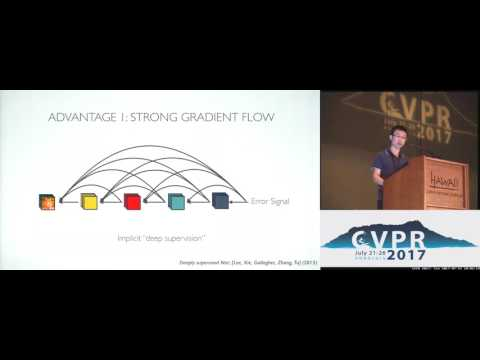

In [0]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [13]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
# determine Loss function and Optimizer


#rms = RMSprop(lr=0.001,decay=1e-6)

#aam_opt = Adam(lr=0.1,decay=1e-6)



model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
####  https://www.kaggle.com/genesis16/densenet-93-accuracy

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, min_lr = 0.000001)

early_stop = EarlyStopping(monitor = "val_loss", patience = 10)

def decay_fn(epoch, lr):
    if epoch < 50:
        return 0.001
    elif epoch >= 50 and epoch < 75:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

csv_logger = CSVLogger('training.log')


In [16]:
#model.fit(X_train, y_train,
#                    batch_size=batch_size,
#                    epochs=epochs,
#                    verbose=1, 
#                    validation_data=(X_test, y_test))

history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=(len(X_train)/batch_size)*5,
    epochs=epochs,
    verbose = 1,
    validation_data=(X_val, y_val),
    callbacks = [lr_scheduler, csv_logger]
)

Epoch 1/35
3516/3515 [==============================] - 542s 154ms/step - loss: 1.3503 - acc: 0.5097 - val_loss: 1.8543 - val_acc: 0.5222
Epoch 2/35
3516/3515 [==============================] - 528s 150ms/step - loss: 0.9411 - acc: 0.6689 - val_loss: 1.0057 - val_acc: 0.6866
Epoch 3/35
3516/3515 [==============================] - 526s 149ms/step - loss: 0.7894 - acc: 0.7240 - val_loss: 1.1683 - val_acc: 0.6772
Epoch 4/35
3516/3515 [==============================] - 526s 149ms/step - loss: 0.6992 - acc: 0.7554 - val_loss: 0.9296 - val_acc: 0.7264
Epoch 5/35
3516/3515 [==============================] - 525s 149ms/step - loss: 0.6359 - acc: 0.7796 - val_loss: 0.7024 - val_acc: 0.7904
Epoch 6/35
3516/3515 [==============================] - 525s 149ms/step - loss: 0.5880 - acc: 0.7963 - val_loss: 0.6702 - val_acc: 0.8052
Epoch 7/35
3516/3515 [==============================] - 525s 149ms/step - loss: 0.5505 - acc: 0.8084 - val_loss: 0.5472 - val_acc: 0.8254
Epoch 8/35
3516/3515 [============

In [17]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 10s 1ms/sample - loss: 0.3223 - acc: 0.9041
Test loss: 0.32226717756986617
Test accuracy: 0.9041


In [18]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


# Conclusion



1.   The most important parameters are : the value "l" which is number of layers in dense block and "k" which is denoted number of filters. 

2. I tried many values of l and k . Ultimately l=6 and k=35 proved to be effective. Also, the total number of parameters increase rapidly with these two parameters.

3. Also, the process of early stopping as well as using decay function for learning rate also helped.


